# Main anaysis

### Setup

#### Imports

In [251]:
import hydra

import numpy as np
import pandas as pd
import plotnine as pn

from hydra.core.global_hydra import GlobalHydra

# Lets us import ibsg modules
import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game

#### Overrides

In [252]:
overrides = [
    "game.universe=100",
    "game.num_signals=100",
    "game.meaning_dist_pi=0.5",
    "simulation/dynamics=imprecise_conditional_imitation",
    "simulation.dynamics.imprecise_imitation_alpha=0.5",
    "simulation.dynamics.max_its=1000", # important to specify maxits
] # n.b.: do not include multirun overrides, we will filter from columns in the dataframe.

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)


#### Helper function to filter data by config data

In [253]:
def get_df_subsetted_by_meaning_dists(df: pd.DataFrame, config) -> pd.DataFrame:
    """Return a subset of the data consistent with the specifications in the curve_metadata config."""
    curve_metadata = config.game

    # See src/get_all_data.py
    universe = df["universe"].astype(str) == str(curve_metadata.universe)
    prior = df["prior"].astype(str) == str(curve_metadata.prior)
    num_signals = df["num_signals"] == curve_metadata.num_signals # this is prob not necessary
    distance = df["distance"] == curve_metadata.distance

    meaning_dist_pi = df["meaning_dist_pi"] == curve_metadata.meaning_dist_pi

    imprecise_imitation_alpha = df["imprecise_imitation_alpha"].isin([curve_metadata.meaning_dist_pi, np.nan]) # allows curve, and constraints to be the same as curve.

    max_its = df["max_its"].isin([config.simulation.dynamics.max_its, np.nan]) # allows curve

    df_subsetted = df[universe & prior & num_signals & num_signals & distance & meaning_dist_pi & imprecise_imitation_alpha & max_its]

    return df_subsetted

#### Load data

In [254]:
all_data_fp = "../../analysis_data/all_data.csv"
df_all = pd.read_csv(all_data_fp)
df_all

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_69316/1129496392.py:2: DtypeWarning: Columns (2,21) have mixed types. Specify dtype option on import or set low_memory=False.


,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,eu_gamma=0.0001873817422860383,eu_gamma=1.5199110829529332e-05,eu_gamma=1.4174741629268048,eu_gamma=2.310129700083158e-05,eu_gamma=0.35111917342151344,eu_gamma=4.281332398719396e-05,eu_gamma=1.072267222010323,eu_gamma=0.11497569953977356,eu_gamma=4.328761281083062,eu_gamma=0.00018329807108324357
0,0.0,1000.0,True,3.738691,3.562866,32.393480,8.580103,0.561553,0.022562,0.000039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,False,0.272999,0.068292,3.234820,1669.606551,0.048918,0.346019,0.204422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,False,0.073509,0.061983,3.239604,1637.595550,0.052302,0.015549,0.011473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,False,0.170885,0.158569,3.309535,1597.080724,0.058833,0.009169,0.012157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,False,0.465127,0.442299,3.526444,1497.846160,0.079878,0.012166,0.022258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82545,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.999448,0.999955,0.329976,0.999932,0.571882,0.999874,0.371517,0.772472,0.239426,0.99946
82546,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.999448,0.999955,0.329976,0.999932,0.571882,0.999874,0.371517,0.772472,0.239426,0.99946
82547,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.999448,0.999955,0.329976,0.999932,0.571882,0.999874,0.371517,0.772472,0.239426,0.99946
82548,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.999448,0.999955,0.329976,0.999932,0.571882,0.999874,0.371517,0.772472,0.239426,0.99946


#### Filter

In [255]:
df = get_df_subsetted_by_meaning_dists(df_all, config)
df

,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,eu_gamma=0.0001873817422860383,eu_gamma=1.5199110829529332e-05,eu_gamma=1.4174741629268048,eu_gamma=2.310129700083158e-05,eu_gamma=0.35111917342151344,eu_gamma=4.281332398719396e-05,eu_gamma=1.072267222010323,eu_gamma=0.11497569953977356,eu_gamma=4.328761281083062,eu_gamma=0.00018329807108324357
0,0.0,1000.0,True,3.738691,3.562866,32.393480,8.580103,0.561553,0.022562,0.000039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,1.0,False,0.272999,0.068292,3.234820,1669.606551,0.048918,0.346019,0.204422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,False,0.073509,0.061983,3.239604,1637.595550,0.052302,0.015549,0.011473,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,False,0.170885,0.158569,3.309535,1597.080724,0.058833,0.009169,0.012157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,False,0.465127,0.442299,3.526444,1497.846160,0.079878,0.012166,0.022258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82545,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.999448,0.999955,0.329976,0.999932,0.571882,0.999874,0.371517,0.772472,0.239426,0.99946
82546,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.999448,0.999955,0.329976,0.999932,0.571882,0.999874,0.371517,0.772472,0.239426,0.99946
82547,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.999448,0.999955,0.329976,0.999932,0.571882,0.999874,0.371517,0.772472,0.239426,0.99946
82548,NaN,NaN,NaN,6.643856,NaN,NaN,0.000000,NaN,NaN,NaN,...,0.999448,0.999955,0.329976,0.999932,0.571882,0.999874,0.371517,0.772472,0.239426,0.99946


In [256]:
df[df["meaning_dist_pi"] == 0.5].discriminative_need_gamma.value_counts()

discriminative_need_gamma
0.127427     3208
0.003360     3208
0.000043     3208
0.000379     3208
0.061585     3208
1.128838     3208
4.832930     3208
0.263665     3208
0.029764     3208
0.000010     3208
0.006952     3208
10.000000    3208
0.000021     3208
0.014384     3208
0.000089     3208
0.001624     3208
2.335721     3208
0.545559     3208
0.000785     3208
0.000183     3208
Name: count, dtype: int64

Make sure seed is a discrete variable

In [257]:
df["seed"] = df["seed"].astype(str)

Separate out observations into curves and simulation points

In [258]:
df_final_points = df[df["point_type"] == "simulation"]
df_ib_bound = df[df["point_type"] == "ib_bound"]
df_mse_bound = df[df["point_type"] == "mse_bound"]

Restrict dynamics

In [259]:
df_final_points = df_final_points[df_final_points["dynamics"] == "imprecise_conditional_imitation"]

How does discriminative_need_gamma range?

In [260]:
df_final_points.discriminative_need_gamma.unique()

array([1.27427499e-01, 3.35981829e-03, 7.84759970e-04, 5.45559478e-01,
       2.33572147e+00, 1.62377674e-03, 8.85866790e-05, 1.43844989e-02,
       2.06913808e-05, 1.00000000e+01, 6.95192796e-03, 1.00000000e-05,
       2.97635144e-02, 2.63665090e-01, 4.83293024e+00, 1.12883789e+00,
       6.15848211e-02, 3.79269019e-04, 4.28133240e-05, 1.83298071e-04])

In [261]:
# How does seed range?
df_final_points.seed.unique()

array(['6.0', '1.0', '0.0', '7.0', '2.0', '5.0', '4.0', '3.0'],
      dtype=object)

In [262]:
# Remember, popuation_init_gamma is nan if we go with the simple uniform sampling init
df_final_points.population_init_tau.unique()

array([nan])

### Visualize

In [263]:
# Make sure complexity max is np.log2(100)
assert np.allclose(df_ib_bound.complexity.max(), np.log2(100))

#### First visualize all data, across initializations and seeds

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 82 rows containing missing values.


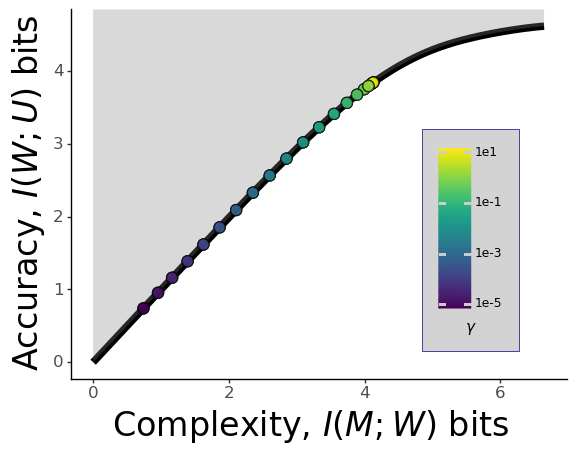

In [264]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=df_ib_bound, mapping=pn.aes(x="complexity", y="accuracy")
    )  
    + pn.geom_line(size=3) # IB curve
    + pn.geom_ribbon(
    mapping=pn.aes(
        x="complexity",
        ymin="accuracy",
        ymax=np.inf,
        ),
        fill="gray",
        alpha=0.3,
    )
    + pn.geom_point( # emergent langs
        data=df_final_points,
        mapping=pn.aes(
            fill="discriminative_need_gamma",
            # fill="imprecise_imitation_gamma",
            # shape="seed",
            ),
        alpha=0.3,
        size=4,
    )
    + pn.labs(fill="$\\gamma$")
    + pn.scale_fill_continuous(
        trans = "log10",
    )
    + pn.xlim([0,np.log2(100)])
    + pn.xlab("Complexity, $I(M;W)$ bits")
    + pn.ylab("Accuracy, $I(W;U)$ bits")

    + pn.theme_classic()
    + pn.theme(
        # Axis font
        axis_title=pn.element_text(size=24),
        axis_text=pn.element_text(size=12),
        # Legend position
        legend_position=(0.75, 0.4),
        # legend_position='none',
        legend_direction = "vertical",
        # Legend box
        legend_background=pn.element_rect(
            fill="lightgrey",
            size=0.5, linetype="solid", 
            color="darkblue",
        ),
    )
    # guide not working, maybe should just use R
    + pn.guides(
        fill = pn.guide_colorbar(
            title_position = "bottom", 
            label_position = "bottom",
            override_aes = {"alpha":0.8},
            ),
    ) 

)
print(plot)

In [265]:
# Double check no min_epsilons are negative
df_final_points[df_final_points.min_epsilon < 0]

,run_num,iteration,is_final_iteration,complexity,accuracy,distortion,mse,eu_gamma,kl_eb,min_epsilon,...,eu_gamma=0.0001873817422860383,eu_gamma=1.5199110829529332e-05,eu_gamma=1.4174741629268048,eu_gamma=2.310129700083158e-05,eu_gamma=0.35111917342151344,eu_gamma=4.281332398719396e-05,eu_gamma=1.072267222010323,eu_gamma=0.11497569953977356,eu_gamma=4.328761281083062,eu_gamma=0.00018329807108324357


#### Distribution of efficiency loss across converged emergent systems

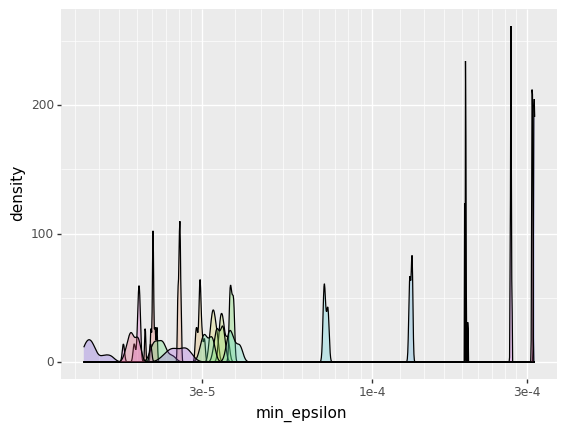

<ggplot: (379507526)>

In [266]:
df_final_points_gamma_discrete = df_final_points.copy()
df_final_points_gamma_discrete["discriminative_need_gamma"] = df_final_points_gamma_discrete["discriminative_need_gamma"].astype(str)

(
    pn.ggplot(
        df_final_points_gamma_discrete,
        pn.aes(
            x="min_epsilon",
            # fill="seed",
            fill="discriminative_need_gamma",
        )
    )
    # + pn.scale_fill_manual(values = fill_values_dict)
    + pn.geom_density(alpha=0.3)
    # + pn.geom_histogram(binwidth=0.01)
    + pn.scale_x_log10()
    # + pn.facet_wrap("discriminative_need_gamma")
    + pn.theme(
        legend_position="none",
    )
)

# Okay, so for the first random seed I picked, the distribution of efficiency loss is highly peaked. This makes some sense, because if we look at the the trajectories, all colors appear to converge to the same respective points on y-axis.

#### Trajectories of efficiency loss

Filter

In [267]:
gamma = 'discriminative_need_gamma'

df_traj_points = df[df["point_type"] == "trajectory"]
df_traj_points["iteration"] = df_traj_points["iteration"]
df_traj_analysis = df_traj_points.copy()


traj_analysis_columns = [
    "iteration", 
    "min_epsilon", 
    "min_epsilon_beta", 
    gamma, 
    "population_init_tau", 
    "complexity", 
    "accuracy", 
    "seed", 
    "kl_eb", 
    "eu_gamma", 
    "min_gnid", 
    "gnid_beta",
]
df_traj_analysis = df_traj_analysis[traj_analysis_columns]
df_traj_analysis

,iteration,min_epsilon,min_epsilon_beta,discriminative_need_gamma,population_init_tau,complexity,accuracy,seed,kl_eb,eu_gamma,min_gnid,gnid_beta
1,1.0,0.204422,1.001313,0.127427,NaN,0.272999,0.068292,6.0,0.346019,0.048918,0.951718,1.000758
2,2.0,0.011473,1.001010,0.127427,NaN,0.073509,0.061983,6.0,0.015549,0.052302,0.793095,1.000707
3,3.0,0.012157,1.001162,0.127427,NaN,0.170885,0.158569,6.0,0.009169,0.058833,0.727763,1.000808
4,4.0,0.022258,1.001717,0.127427,NaN,0.465127,0.442299,6.0,0.012166,0.079878,0.653811,1.001010
5,5.0,0.041995,1.006263,0.127427,NaN,1.163845,1.118733,6.0,0.014627,0.145757,0.578275,1.001919
...,...,...,...,...,...,...,...,...,...,...,...,...
80755,932.0,0.000022,1.013081,0.000183,NaN,1.625352,1.617956,3.0,0.005215,0.976074,0.001586,1.013081
80756,954.0,0.000022,1.013081,0.000183,NaN,1.625170,1.617777,3.0,0.005221,0.976071,0.001543,1.013081
80757,977.0,0.000021,1.013081,0.000183,NaN,1.624990,1.617600,3.0,0.005227,0.976068,0.001502,1.013081
80758,999.0,0.000021,1.013081,0.000183,NaN,1.624827,1.617439,3.0,0.005232,0.976065,0.001464,1.013081


In [268]:
# Ensure iteration max is the same as max_its specified by game config
df_traj_analysis.iteration.max()

1000.0

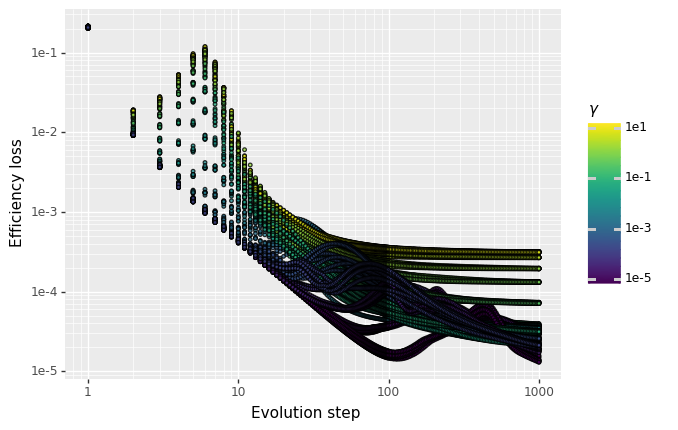

In [269]:
plot = (
    pn.ggplot(
        df_traj_analysis,
        pn.aes(
            x="iteration", 
            y="min_epsilon", 
            fill="discriminative_need_gamma",
            # color="seed",
        ),
    )
    + pn.geom_point(
        pn.aes(
            
        ),
        # size=0.5,
        size=1,
        alpha=0.8,
        )
    # + pn.geom_line()
    + pn.labs(fill="$\\gamma$")    
    + pn.xlab("Evolution step")
    + pn.ylab("Efficiency loss")

    + pn.scale_y_continuous(
        trans='log10', 
        # limits=[1e-5, 0.1],
    )
    # + pn.ylim(0,0.1)
    # + pn.xlim(0,50)
    + pn.scale_fill_continuous(trans = 'log10')
    + pn.scale_x_log10()
)
print(plot)

Helper function to get mean and confidence intervals for a variable, grouped by gamma and iteration

In [270]:
from scipy import stats

# Calculate the mean and confidence intervals for each iteration
def mean_confidence_interval(data: pd.DataFrame, confidence=0.95) -> tuple[float]:
    n = len(data)
    mean, se = np.mean(data), stats.sem(data)
    interval = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return (mean, mean - interval, mean + interval)

def mean_conf_df(trajectory_data: pd.DataFrame, colname: str):
    df_summary = df_traj_analysis.groupby(['iteration', 'discriminative_need_gamma'])[colname].apply(mean_confidence_interval).apply(pd.Series)
    df_summary.columns = [f'mean_{colname}', 'lower_ci', 'upper_ci']
    df_summary = df_summary.reset_index()
    return df_summary


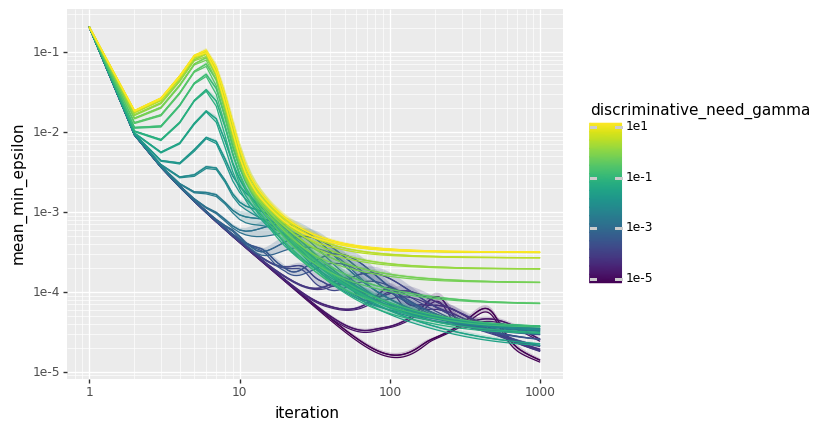

<ggplot: (379350695)>

In [271]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

#### Zoom in on the spike in inefficiency

/Users/nathanielimel/miniforge3/envs/ibsg/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 190 rows containing missing values.


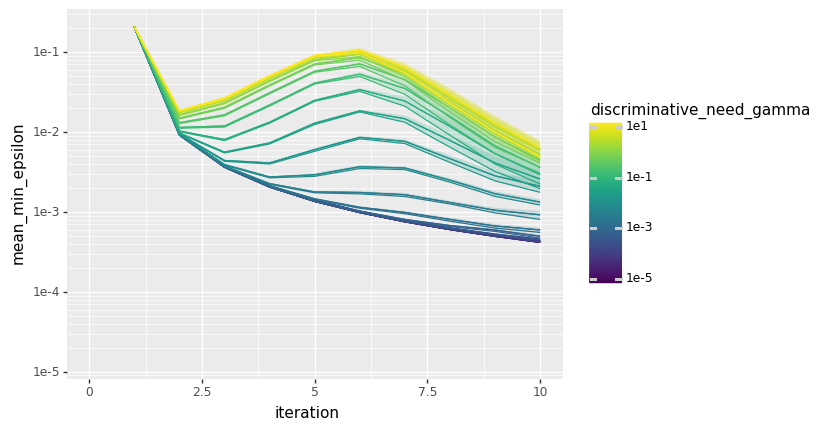

<ggplot: (819237060)>

In [272]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")  
   + pn.scale_y_log10() 
   + pn.xlim(0,10)
)

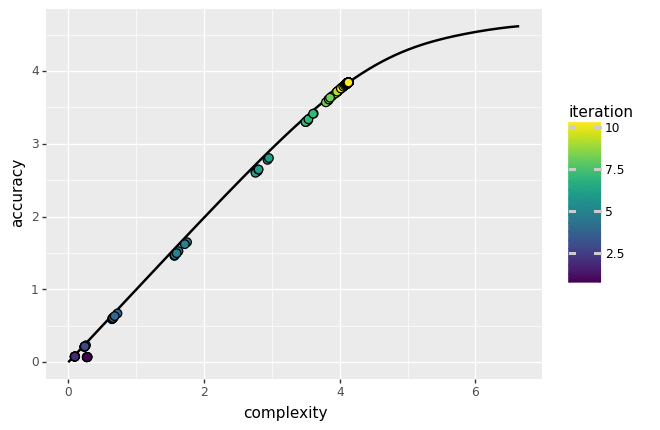

<ggplot: (819998267)>

In [273]:
# I'm so curious to see if we can see this on the trajectories. Zoom in on gamma=1000

df_traj_gamma_3 = df_traj_analysis[df_traj_analysis["discriminative_need_gamma"] == np.max(df_traj_analysis["discriminative_need_gamma"])]

(
    pn.ggplot(
        df_traj_gamma_3,
        pn.aes(
            x="complexity",
            y="accuracy",
            # color="iteration",
            # size="iteration",
            # color="discriminative_need_gamma",
        ),
    )
    # + pn.scale_size_continuous( limits=[1,5])    
    + pn.geom_line(df_ib_bound, size=1, color="black")
    + pn.geom_point(
        pn.aes(
            fill="iteration",
        ),
        size=3,        
    )
    + pn.scale_fill_continuous( 
        limits=[1,10]
    )


    # + pn.ylim(0,3)
    # + pn.xlim(0,3)
    # + pn.facet_wrap("discriminative_need_gamma")
)

#### Visualize comp vs. EU

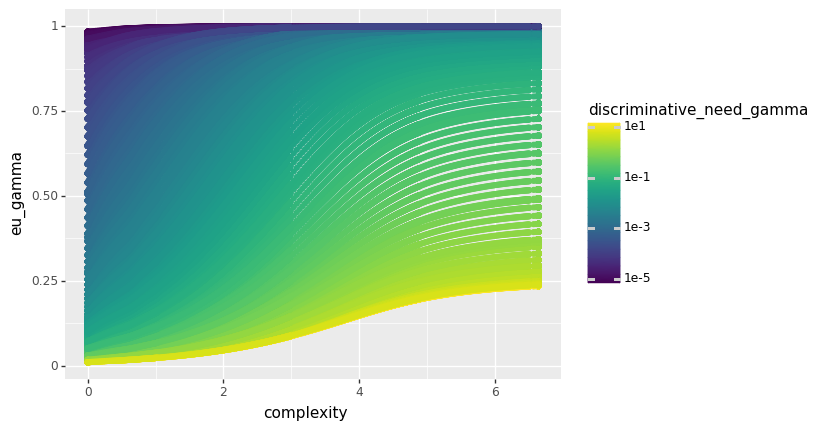

<ggplot: (814857024)>

In [274]:
# I'd like to know what the IB curves achieve in terms of their EU.

eu_cols = [colname for colname in df_ib_bound.columns if "eu_gamma=" in colname]
cols = ["complexity", "accuracy",] + eu_cols


df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)

# Yet another bandaid for string parsing the 0.5 width.

df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1]).astype(float)

# df_ib_eu

(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_continuous(trans = "log10")
    + pn.geom_point()
)

together?

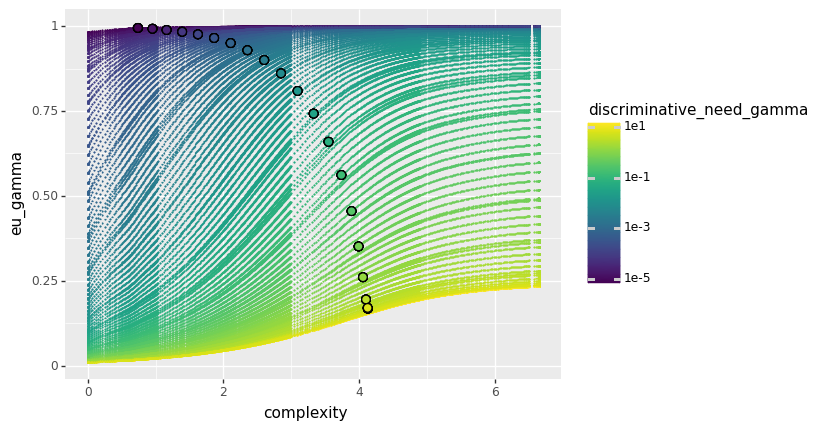

<ggplot: (805569500)>

In [275]:
(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.geom_point(shape="+", size=0.25,)

    # Now the simulation data
    + pn.geom_point(
        df_final_points,
        pn.aes(
            fill="discriminative_need_gamma",
        ),
        shape="o",
        color="black",
        size=3,
    )
    + pn.scale_color_continuous(trans = "log10")
    + pn.scale_fill_continuous(trans = "log10")    

    # + pn.ylim(0, 0.25)
)

complexity vs beta with utility as color (heatmap)


In [276]:
# Sanity check that a bijective sender and bayesian receiver team will achieve at most 0.25 expected utility in the highest gamma game, because of the meaning confusion probabilities

game = Game.from_hydra(config)

encoder = np.eye(len(game.universe))
# decoder = encoder.T # not nec. ib
decoder = (encoder * game.prior[:, None]) / (encoder.T @ game.prior) @ game.meaning_dists

optimal_team = optimal_team = game.meaning_dists @ encoder @ decoder @ game.meaning_dists
high_gamma_utility = np.eye(len(game.universe))

# expected utility
np.sum(game.prior * (optimal_team * high_gamma_utility))

0.2342627097372711

In [277]:
# check that without confusion we achieve 1.0 utility
np.sum(game.prior * (np.eye(len(game.universe)) * game.utility))

1.0

is it possible to view trajectories too? yes.

How to read the below plot: lines are ib optima, circles are trajectories of emergent systems.

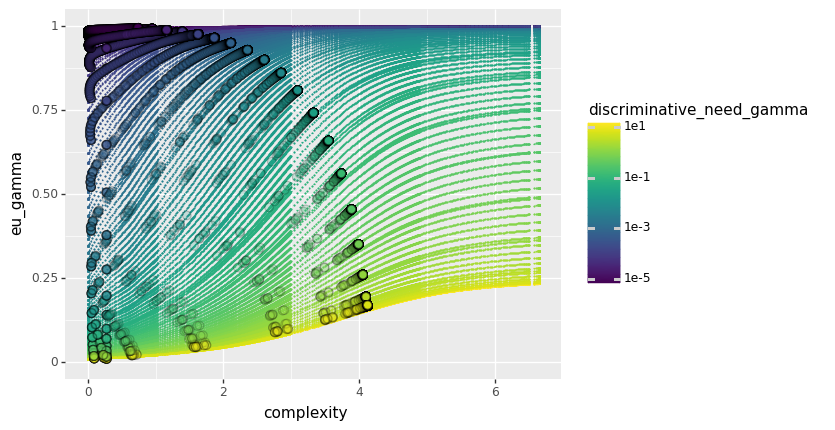

<ggplot: (817426514)>

In [278]:
df_ib_eu = df_ib_bound[cols].melt(
    id_vars=["complexity", "accuracy",], 
    value_vars=eu_cols, 
    var_name="discriminative_need_gamma", 
    value_name="eu_gamma",
)
df_ib_eu["discriminative_need_gamma"] = df_ib_eu["discriminative_need_gamma"].apply(lambda s: s.split("eu_gamma=")[1]).astype(float)

(
    pn.ggplot(
        df_ib_eu,
        pn.aes(
            x="complexity",
            y="eu_gamma",
            color="discriminative_need_gamma",
        ),
    )
    + pn.scale_color_continuous(trans = "log10")

    + pn.geom_point(
        shape="+", 
        size=0.25,
    )

    # Now the simulation data
    + pn.geom_point(
        data=df_traj_analysis, # why does the highest gamma always get overplotted? maybe we should drop anyway...
        mapping=pn.aes(
            # size="iteration",
            fill="discriminative_need_gamma",
        ),
        shape="o",
        size=3,
        alpha=0.2,
        color="black",
    )
    + pn.scale_fill_continuous(trans = "log10")
    + pn.ylim(0,1)
)

#### Visualize kl_eb over time

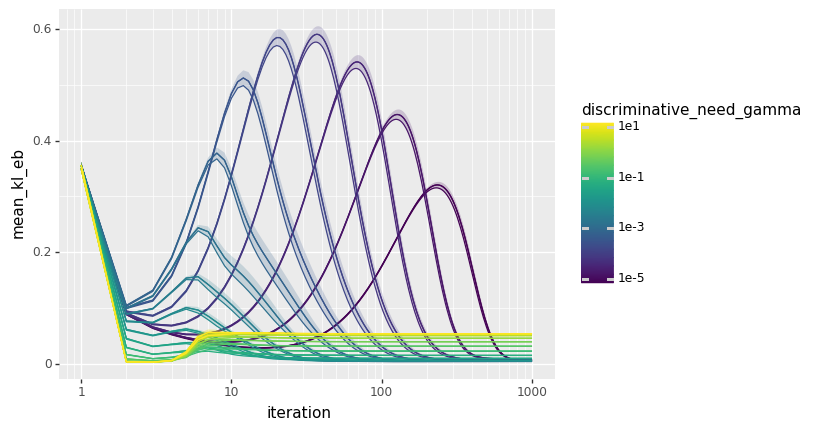

<ggplot: (811927234)>

In [279]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "kl_eb"),
      pn.aes(
         x="iteration",
         y="mean_kl_eb",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()
)

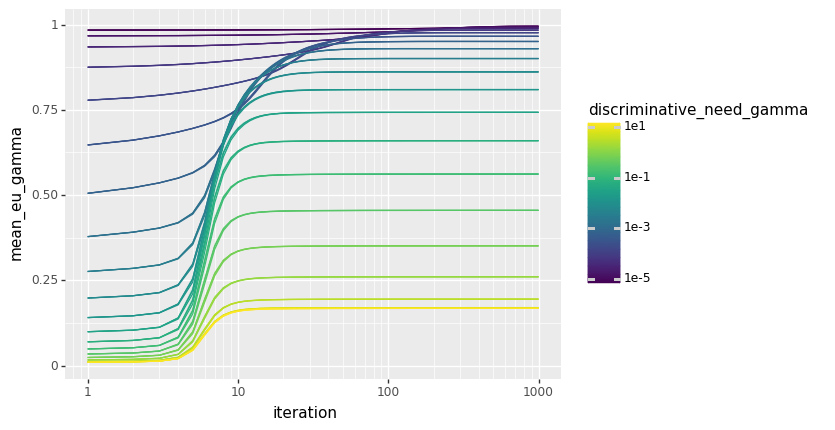

<ggplot: (815748139)>

In [244]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "eu_gamma"),
      pn.aes(
         x="iteration",
         y="mean_eu_gamma",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   # + pn.scale_y_log10()
)

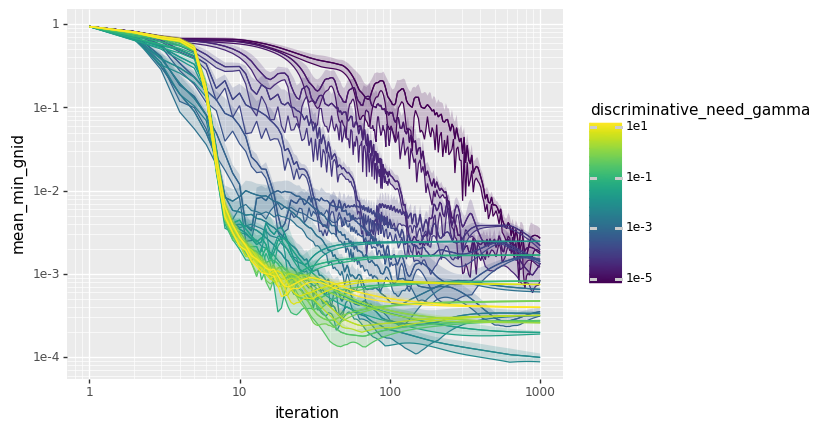

<ggplot: (393055509)>

In [245]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_gnid"),
      pn.aes(
         x="iteration",
         y="mean_min_gnid",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

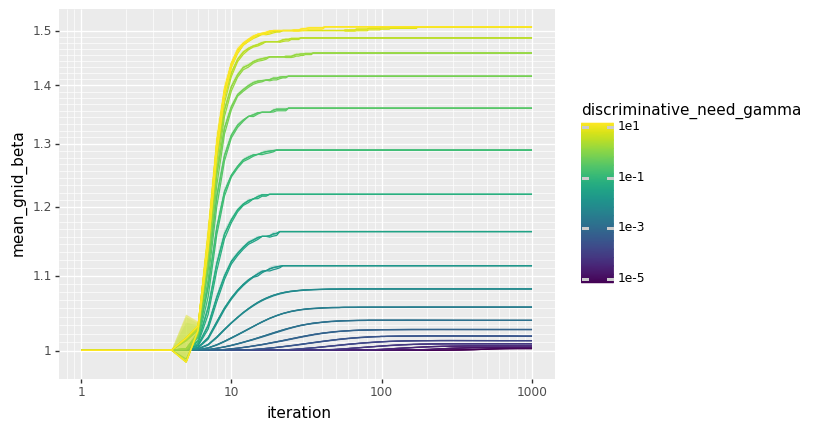

<ggplot: (814414488)>

In [246]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "gnid_beta"),
      pn.aes(
         x="iteration",
         y="mean_gnid_beta",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

N.B., this is different from beta fitted by min epsilon!

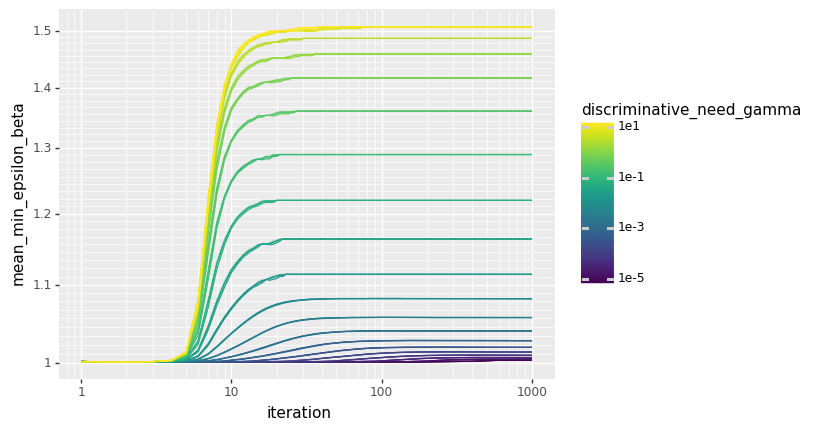

<ggplot: (805448059)>

In [247]:
(
   pn.ggplot(
      mean_conf_df(df_traj_analysis, "min_epsilon_beta"),
      pn.aes(
         x="iteration",
         y="mean_min_epsilon_beta",
         color="discriminative_need_gamma",
         group="discriminative_need_gamma",
      )
   )
   + pn.geom_line()
   + pn.geom_ribbon(
      pn.aes(
         ymin = "lower_ci",
         ymax = "upper_ci",
         fill = "discriminative_need_gamma",
      ),
      alpha=0.2,
   )
   + pn.scale_color_continuous(trans = "log10")
   + pn.scale_fill_continuous(trans = "log10")   
   + pn.scale_x_log10()
   + pn.scale_y_log10()
)

would be interesting to compare these betas, but i'll wait until someone asks